# FAST-EM Montage
---

#### Overview
The purpose of this notebook is to montage (or stitch together) individual sections (or layers) of image data. This is done by first gathering the set of neighboring tiles in each section and then generating point matches from these neighboring images (or tile pairs). `render-ws` includes functionality for gathering the set of neighboring tiles as well as for generating point matches, accessed by making calls to `renderapi.client.tilePairClient` and `renderapi.client.pointMatchClient`, respectively.

In [1]:
import re
from pathlib import Path

from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import altair as alt
import matplotlib.pyplot as plt

import renderapi
import icatapi

#### Settings

In [12]:
# pandas display settings
pd.set_option('display.max_colwidth', 20)

# Indirectly enable autocomplete
%config Completer.use_jedi = False

# `altair` settings
alt.data_transformers.disable_max_rows();

# Suppress output of terminal that crashes notebook
import sys
sys.stdout = open('/dev/stdout', 'w')

## 1) Set up `render-ws` environment
---

#### Connect to `render-ws`

In [3]:
# `render-ws` parameters
owner = 'akievits'
project = '20220610_UMCU'
dir_project = Path(f"/long_term_storage/{owner}/FAST-EM/{project}")

# Create a renderapi.connect.Render object
# ----------------------------------------
render_connect_params = {
    'host': 'sonic.tnw.tudelft.nl',
    'port': 8080,
    'owner': owner,
    'project': project,
    'client_scripts': '/home/catmaid/render/render-ws-java-client/src/main/scripts',
    'memGB': '2G'
}
render = renderapi.connect(**render_connect_params)
render.make_kwargs()

{'host': 'http://sonic.tnw.tudelft.nl',
 'port': 8080,
 'owner': 'akievits',
 'project': '20220610_UMCU',
 'client_scripts': '/home/catmaid/render/render-ws-java-client/src/main/scripts',
 'client_script': '/home/catmaid/render/render-ws-java-client/src/main/scripts/run_ws_client.sh',
 'memGB': '2G'}

#### Set montage stacks 

In [5]:
# Infer stack and section info
# ----------------------------
stacks = renderapi.render.get_stacks_by_owner_project(render=render)
stacks_2_montage = ['corrected']
match_collections = {k: v for k, v in zip(stacks_2_montage,
                                          [f"{project}_{stack}_points" for stack in stacks_2_montage])}

# Output
# ------
out = f"""\
project directory... {dir_project} | Exists: {dir_project.exists()}
all stacks.......... {stacks}
stacks to montage... {stacks_2_montage}
match collections... {match_collections}
...
"""
print(out)

# Create project DataFrame
# ------------------------
df_project = icatapi.create_stacks_DataFrame(stacks=stacks_2_montage,
                                             render=render)
df_project.groupby('stack')\
          .apply(lambda x: x.head(3))

tileId    z   width  height   minint   maxint  \
stack                                                                  
corrected 0  cor-S000-000x000  0.0  6400.0  6400.0  29950.0  35620.0   
          1  cor-S000-000x001  0.0  6400.0  6400.0  29950.0  35620.0   
          2  cor-S000-000x002  0.0  6400.0  6400.0  29950.0  35620.0   

                imagePyramid               tforms      stack       sectionId  \
stack                                                                          
corrected 0  [0, 1, 2, 3, 4]  [M=[[1.000000,0....  corrected  EPON_80nm_s001   
          1  [0, 1, 2, 3, 4]  [M=[[1.000000,0....  corrected  EPON_80nm_s001   
          2  [0, 1, 2, 3, 4]  [M=[[1.000000,0....  corrected  EPON_80nm_s001   

             imageRow  imageCol  
stack                            
corrected 0         0         0  
          1         0         1  
          2         0         2

## 2) Generate point matches
---

#### Collect tile pairs

Tile pairs are any two tiles that overlap with each other (possibly including diagonally). Collection of tile pairs is generated from a `render-python` client script. This client selects a set of tiles `p` based on its position in a stack and then searches for nearby `q` tiles using geometric parameters.

script | code
------ | ----
client script | [`renderapi.client.tilePairClient`](https://github.com/fcollman/render-python/blob/721ac8845e3067af6c81f3c67f2c0fa24fb1723c/renderapi/client/client_calls.py#L129)
java script | [`TilePairClient.java`](https://github.com/saalfeldlab/render/blob/master/render-ws-java-client/src/main/java/org/janelia/render/client/TilePairClient.java)

In [6]:
from icatapi.montage import get_tile_pairs_4_montage

In [7]:
# Initialize tile pairs DataFrame
df_pairs = pd.DataFrame()

# Loop through montage stacks
for stack in tqdm(stacks_2_montage):

    # Get tile pairs for each stack
    df = get_tile_pairs_4_montage(stack=stack,
                                  render=render)
    df_pairs = pd.concat([df_pairs, df])

# Preview
out = f"{len(df_pairs)} tile pairs"
print(out + '\n' + '.'*len(out))

df_pairs.reset_index(drop=True, inplace=True)
df_pairs.groupby('stack')\
        .apply(lambda x: x.sample(7))

  0%|          | 0/1 [00:00<?, ?it/s]

stack    z       p.groupId              p.id  \
stack                                                             
corrected 97   corrected  0.0  EPON_80nm_s001  cor-S000-004x006   
          258  corrected  1.0  EPON_80nm_s002  cor-S001-001x008   
          377  corrected  1.0  EPON_80nm_s002  cor-S001-007x005   
          376  corrected  1.0  EPON_80nm_s002  cor-S001-007x004   
          117  corrected  0.0  EPON_80nm_s001  cor-S000-005x006   
          213  corrected  0.0  EPON_80nm_s001  cor-S000-010x003   
          166  corrected  0.0  EPON_80nm_s001  cor-S000-007x009   

              p.relativePosition       q.groupId              q.id  \
stack                                                                
corrected 97                LEFT  EPON_80nm_s001  cor-S000-004x007   
          258               LEFT  EPON_80nm_s002  cor-S001-001x009   
          377                TOP  EPON_80nm_s002  cor-S001-008x005   
          376               LEFT  EPON_80nm_s002  cor-S001-007x005   
          117                TOP  EPON_80nm_s001  cor-S000-006x006   
          213               LEFT  EPON_80nm_s001  cor-S000-010x004   
          166               LEFT  EPON_80nm_s001  cor-S000-007x010   

              q.relativePosition  
stack                             
corrected 97               RIGHT  
          258              RIGHT  
          377             BOTTOM  
          376              RIGHT  
          117             BOTTOM  
          213              RIGHT  
          166              RIGHT

### Run `pointMatchClient`
##### Set `SIFT` & `RANSAC` parameters

In [8]:
from renderapi.client import (MatchDerivationParameters,
                              FeatureExtractionParameters,
                              SiftPointMatchOptions)

In [9]:
# `RANSAC` parameters
match_params = MatchDerivationParameters(matchIterations=None,
                                         matchMaxEpsilon=25,        # maximal alignment error
                                         matchMaxNumInliers=None,
                                         matchMaxTrust=None,
                                         matchMinInlierRatio=0.05,  # minimal inlier ratio
                                         matchMinNumInliers=7,      # minimal number of inliers
                                         matchModelType='RIGID',    # expected transformation
                                         matchRod=0.92)             # closest/next closest ratio
# `SIFT` parameters
feature_params = FeatureExtractionParameters(SIFTfdSize=8,          # feature descriptor size
                                             SIFTmaxScale=0.20,     # (width/height *) maximum image size
                                             SIFTminScale=0.05,     # (width/height *) minimum image size
                                             SIFTsteps=7)           # steps per scale octave
# Combined `SIFT` & `RANSAC` parameters
sift_options = SiftPointMatchOptions(**{**match_params.__dict__,
                                        **feature_params.__dict__})
# Add clipping options
sift_options.clipWidth = 1000   # N pixels included in rendered clips of LEFT/RIGHT oriented montage tiles
sift_options.clipHeight = 1000  # N pixels included in rendered clips of TOP/BOTTOM oriented montage tiles

# Preview
list(sift_options.to_java_args())

['--SIFTfdSize',
 '8',
 '--SIFTmaxScale',
 '0.2',
 '--SIFTminScale',
 '0.05',
 '--SIFTsteps',
 '7',
 '--matchMaxEpsilon',
 '25',
 '--matchMinInlierRatio',
 '0.05',
 '--matchMinNumInliers',
 '7',
 '--matchModelType',
 'RIGID',
 '--matchRod',
 '0.92',
 '--clipWidth',
 '1000',
 '--clipHeight',
 '1000']

#### \*\****COMPUTATIONALLY EXPENSIVE*** \**

##### Run `pointMatchClient` on `N_cores`

In [10]:
from icatapi.montage import generate_point_matches

In [11]:
# Set number of cores and batch size
N_cores = 10
batch_size = 12

# Generate point matches
generate_point_matches(df_pairs,
                       match_collections=match_collections,
                       sift_options=sift_options,
                       excludeAllTransforms=True,
                       N_cores=N_cores,
                       batch_size=batch_size,
                       render=render)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

## 3) Analyze point matches
---

### Collect point matches
Sort of forced to iterate through tile pairs because no data is returned for tile pairs with no matches

In [13]:
# Collect point matches from montage stacks
df_matches = pd.DataFrame()
for stack in tqdm(stacks_2_montage):
    # Get matches per stack
    df = icatapi.montage.get_matches_within_stack(stack=stack, match_collection=match_collections[stack],
                                  render=render)
    df_matches = pd.concat([df_matches, df])

# Merge with DataFrame of tile pairs to also get empty matches
df_matches = pd.merge(
    df_matches,
    df_pairs.rename(columns={'p.groupId': 'pGroupId',
                             'q.groupId': 'qGroupId',
                             'p.id': 'pId',
                             'q.id': 'qId'})\
            .drop(['p.relativePosition',
                   'q.relativePosition'], axis=1, errors='ignore'),
    how='outer',
    on=['stack', 'z', 'pGroupId', 'pId', 'qGroupId', 'qId'])

# Add row/col indices
df_matches[['pc', 'pr']] = np.stack(df_matches['pId'].apply(lambda x:\
                                    [int(i) for i in re.findall(r'\d+', x)[-2:]]))
df_matches[['qc', 'qr']] = np.stack(df_matches['qId'].apply(lambda x:\
                                    [int(i) for i in re.findall(r'\d+', x)[-2:]]))

# Preview
out = f"""\
{len(df_matches.dropna())} / \
{len(df_matches)} \
({len(df_matches.dropna())/len(df_matches):.1%}) \
tile pair matches"""
print(out + '\n' + '.'*len(out))
df_matches.groupby('stack')\
          .apply(lambda x: x.sample(3))

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

/home/akievits/miniconda3/envs/fastem/lib/python3.9/site-packages/pandas/core/reshape/merge.py:916: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  key_col = Index(lvals).where(~mask_left, rvals)


stack    z        pGroupId               pId  pc  pr  \
stack                                                                     
corrected 158  corrected  0.0  EPON_80nm_s001  cor-S000-007x006   7   6   
          11   corrected  0.0  EPON_80nm_s001  cor-S000-000x005   0   5   
          360  corrected  1.0  EPON_80nm_s002  cor-S001-007x001   7   1   

                     qGroupId               qId  qc  qr     N  \
stack                                                           
corrected 158  EPON_80nm_s001  cor-S000-007x007   7   7  46.0   
          11   EPON_80nm_s001  cor-S000-001x005   1   5  45.0   
          360  EPON_80nm_s002  cor-S001-008x001   8   1  42.0   

                         matches.p            matches.q            matches.w  
stack                                                                         
corrected 158  [[6202.230894784...  [[432.6233533644...  [1.0, 1.0, 1.0, ...  
          11   [[4929.270266469...  [[4929.074577271...  [1.0, 1.0, 1.0, ...  
          360  [[1621.212374788...  [[1713.283317195...  [1.0, 1.0, 1.0, ...

### Heatmaps of point matches

#### East-West point matches

In [14]:
icatapi.plotting.plot_matches_within_section(df_matches,
                                             direction='east-west',
                                             width=150,
                                             height=150)

alt.FacetChart(...)

#### North-South point matches

In [15]:
icatapi.plotting.plot_matches_within_section(df_matches,
                                             direction='north-south',
                                             width=150,
                                             height=150)

alt.FacetChart(...)

## 4) Montage
---

#### Edit `montage.json`

In [16]:
import json
from pprint import pprint

In [17]:
# Load montage json template
template_montage_json = Path(f'/home/{owner}/iCAT-workflow/templates/montage.json')
with template_montage_json.open('r') as json_data:
    montage_settings = json.load(json_data)

# Edit montage settings for each montage stack
for (stack, z, sectionId), df in df_project.loc[(df_project['stack'].isin(stacks_2_montage))] \
                                           .groupby(['stack', 'z', 'sectionId']):

    # Edit BigFeta solver schema
    montage_settings['first_section'] = z
    montage_settings['last_section'] = z
    montage_settings['solve_type'] = 'montage'
    montage_settings['transformation'] = 'rigid'
    montage_settings['log_level'] = 'INFO'

    # Edit input stack data
    montage_settings['input_stack']['owner'] = owner
    montage_settings['input_stack']['project'] = project
    montage_settings['input_stack']['name'] = stack

    # Edit point match stack data
    montage_settings['pointmatch']['owner'] = owner
    montage_settings['pointmatch']['name'] = match_collections[stack]

    # Edit output stack data
    montage_settings['output_stack']['owner'] = owner
    montage_settings['output_stack']['project'] = project
    montage_settings['output_stack']['name'] = f'{stack}_montaged'

    # Edit regularization parameters
    montage_settings['regularization']['default_lambda'] = 0.10     # default: 0.005
    montage_settings['regularization']['translation_factor'] = 0.10  # default: 0.005
    montage_settings['regularization']['thinplate_factor'] = 1e-5     # default: 1e-5

    # Export montage settings to
    montage_json = dir_project / '_jsons_montage' / stack / f"{sectionId}_montage.json"
    montage_json.parent.mkdir(parents=True, exist_ok=True)
    with montage_json.open('w') as json_data:
        json.dump(montage_settings, json_data, indent=2)

# Sample montage json
print(montage_json)
print('...')
pprint(montage_settings)

### Run `BigFeta` montage

In [18]:
import os
import subprocess

In [19]:
# Path to `BigFeta`
cwd = Path.cwd().as_posix()
BigFeta_dir = Path('/home/catmaid/BigFeta/')

# Loop through each section of montage stacks
for (stack, z, sectionId), df in tqdm(df_project.loc[(df_project['stack'].isin(stacks_2_montage))]\
                                                .groupby(['stack', 'z', 'sectionId'])):

    # Select montage json
    montage_json = dir_project / '_jsons_montage' / stack / f"{sectionId}_montage.json"

    # Call `BigFeta.BigFeta` process -- have to switch to BigFeta directory
    os.chdir(BigFeta_dir.as_posix())
    subprocess.run(['python', '-m', 'bigfeta.bigfeta', '--input_json', montage_json.as_posix()])
    os.chdir(cwd)

  0%|          | 0/2 [00:00<?, ?it/s]

/home/akievits/miniconda3/envs/fastem/lib/python3.9/site-packages/argschema/utils.py:346: FutureWarning: '--transform_apply' is using old-style command-line syntax with each element as a separate argument. This will not be supported in argschema after 2.0. See http://argschema.readthedocs.io/en/master/user/intro.html#command-line-specification for details.
  warnings.warn(warn_msg, FutureWarning)
INFO:bigfeta.utils:
 loaded 121 tile specs from 1 zvalues in 0.1 sec using interface: mongo
INFO:__main__: A created in 0.4 seconds
INFO:__main__:
 solved in 0.0 sec
 precision [norm(Kx-Lm)/norm(Lm)] = 1.1e-08
 error     [norm(Ax-b)] = 1067.669
 [mean(Ax) +/- std(Ax)] : 0.0 +/- 6.0
 [mean(error mag) +/- std(error mag)] : 4.7 +/- 3.7
INFO:__main__:
 scales: 0.98 +/- 0.00, 0.98 +/- 0.00
INFO:bigfeta.utils:
ingesting results to http://sonic.tnw.tudelft.nl:8080 akievits__20220610_UMCU__corrected_montaged
INFO:bigfeta.utils:render output is going to /dev/null
INFO:__main__: total time: 3.8
/home/ak

## 5) Inspect montaged stacks
---


#### Tile map

  0%|          | 0/2 [00:00<?, ?it/s]

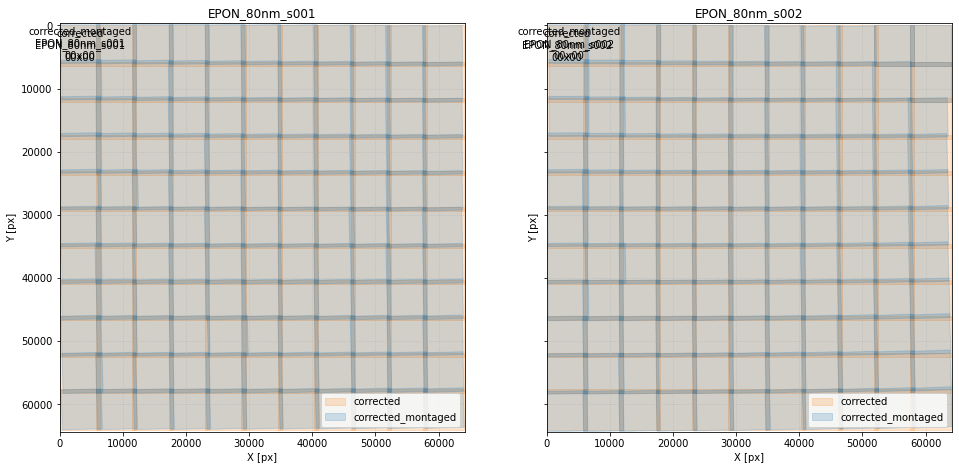

In [20]:
stacks = renderapi.render.get_stacks_by_owner_project(render=render)
stacks_2_plot = [stack for stack in stacks if '_montaged' in stack] +\
                 stacks_2_montage

icatapi.plot_tile_map(stacks=stacks_2_plot,
                      render=render)

#### Plot stacks

  0%|          | 0/4 [00:00<?, ?it/s]

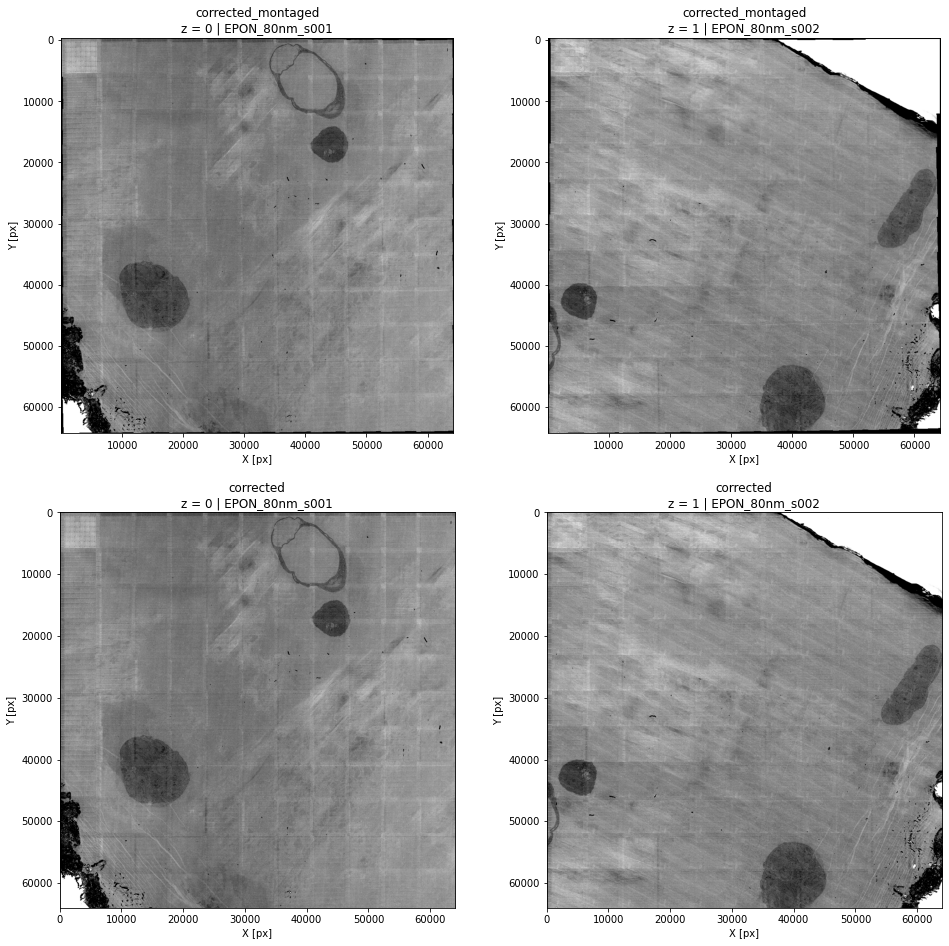

In [21]:
icatapi.plot_stacks(stacks_2_plot,
                    maxTileSpecsToRender=1000,
                    render=render)

## Scale montage
---

In [64]:
from matplotlib.transforms import Affine2D as AffineMPL
from renderapi.transform import AffineModel as AffineRender

from icatapi.render_pandas import create_stack_DataFrame, upload_stack_DataFrame
from icatapi.render_transforms import scale_stack

#### Determine scaling factor
Scale each tileset by the same factor. So determine the average scale and multiply by that

In [66]:
# Collect scaling factors
scales_x = []
scales_y = []

# Create stack DataFrame
df_stack = create_stack_DataFrame(stack='corrected_montaged',
                                  render=render)

# Loop through sections
for z, layer in tqdm(df_stack.groupby('z'),
                     total=len(df_stack['z'].unique())):

    # Get transform data
    columns = ['M00', 'M10', 'M01', 'M11', 'B0', 'B1']
    tforms = pd.DataFrame(layer['tforms']\
               .apply(lambda x: x[0].dataString)\
               .str.split(' ', expand=True).values, columns=columns)\
               .astype(float)

    # Extract scale from affine transform
    M = AffineMPL(np.array([[tforms['M00'].mean(), tforms['M01'].mean(), 0],
                            [tforms['M10'].mean(), tforms['M11'].mean(), 0],
                            [                   0,                    0, 1]]))
    R, S = np.linalg.qr(M.get_matrix())
    mask = np.diag(S) < 0.
    S[mask, :] *= -1.
    # Set scale
    sx = 1/S[0,0]
    sy = 1/S[1,1]

    # Collect scaling factors
    scales_x.append(sx)
    scales_y.append(sy)

# Put into arrays
scales_x = np.array(scales_x)
scales_y = np.array(scales_y)
# Find average
sx = scales_x.mean()
sy = scales_y.mean()

# Out
sx, sy

  0%|          | 0/6 [00:00<?, ?it/s]

(1.6182338238725418, 1.6182338238725418)

#### Scale stack

In [68]:
# Scale stack
scale_stack(stack_in='corrected_montaged',
            stack_out='corrected_stitched',
            sx=sx,
            sy=sy,
            translate=True,
            render=render)

#### Plot tiles

  0%|          | 0/6 [00:00<?, ?it/s]

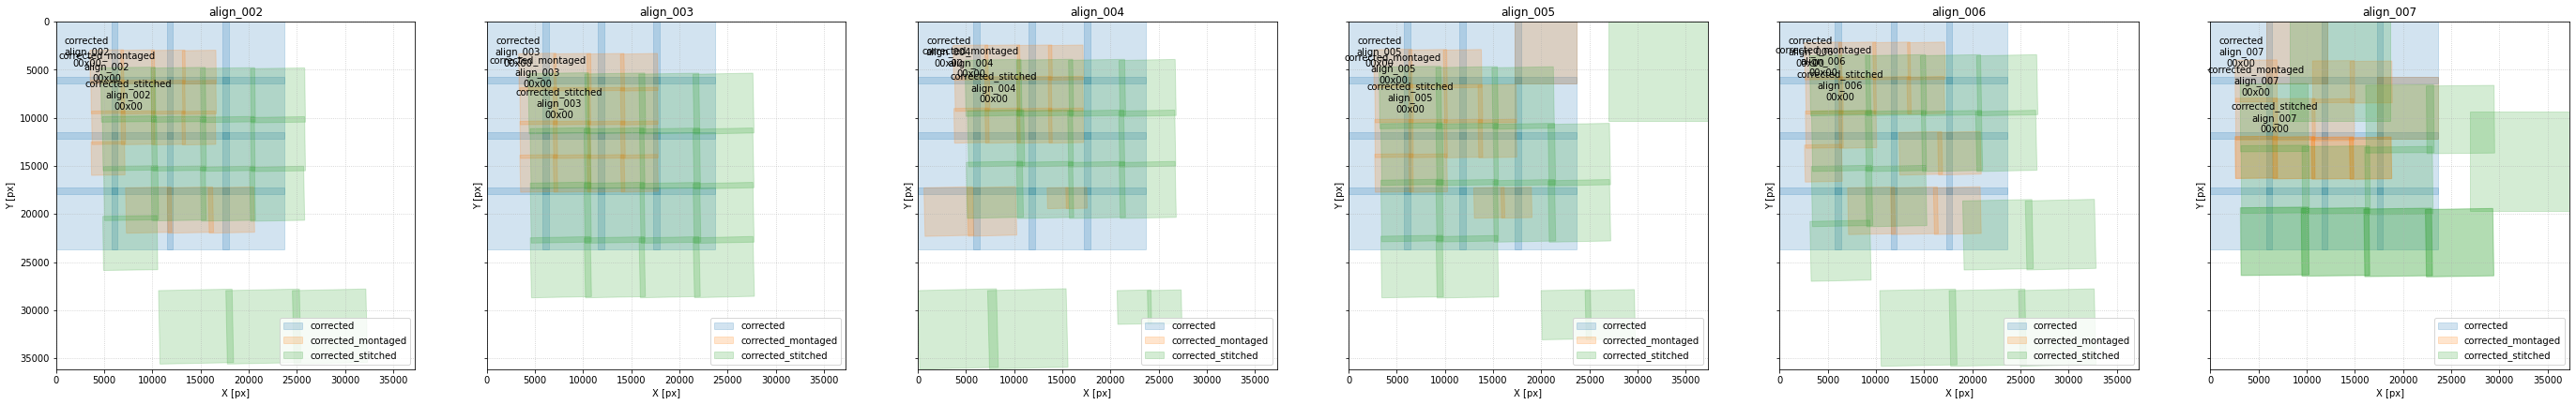

In [70]:
stacks_2_plot = stacks_2_montage + ['corrected_montaged', 'corrected_stitched']

icatapi.plotting.plot_tile_map(stacks=stacks_2_plot,
                               render=render)

## Remove island tiles
---
#### Look at distribution of transformations

In [103]:
df_stack = create_stack_DataFrame(stack='corrected_stitched',
                                  render=render)

T_cols = ['M00', 'M10', 'M01', 'M11', 'B0', 'B1']
df_stack[T_cols] = pd.DataFrame(df_stack['tforms']\
           .apply(lambda x: x[0].dataString)\
           .str.split(' ', expand=True).values, columns=T_cols)\
           .astype(float)
tforms = df_stack.loc[:, T_cols]
tforms

,M00,M10,M01,M11,B0,B1
0,0.545139,-0.007058,0.007058,0.545139,3511.398429,2973.066201
1,0.543678,-0.007877,0.007877,0.543678,6731.126339,2991.129461
2,0.543711,-0.007521,0.007521,0.543711,9906.019103,3008.580441
3,0.543494,-0.007569,0.007569,0.543494,13117.756064,3027.960442
4,0.542827,-0.007792,0.007792,0.542827,3614.036602,6109.935969
...,...,...,...,...,...,...
91,0.676513,-0.011026,0.011026,0.676513,14420.401891,12071.569245
92,0.680897,-0.007072,0.007072,0.680897,2551.163788,11961.999998
93,0.680479,-0.008120,0.008120,0.680479,6457.207447,12005.646522
94,0.679234,-0.009213,0.009213,0.679234,10480.037181,12038.240217


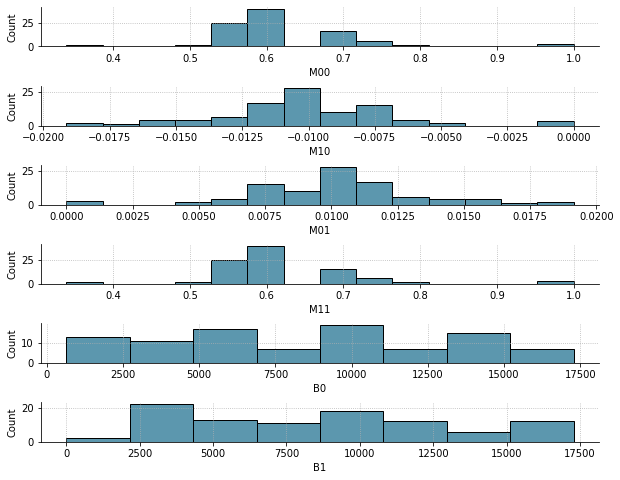

In [104]:
fig, axes = plt.subplots(nrows=len(tforms.columns),
                         figsize=(10, 8))
for i, k in enumerate(df_stack[T_cols]):
    sns.histplot(tforms[k], ax=axes[i], color='#267593')
#     sns.boxplot(x=k, data=tforms, orient='h', whis=None, fliersize=3, ax=axes[i])
#     sns.stripplot(x=k, data=tforms, orient='h', color='.3', size=3, ax=axes[i])
    axes[i].grid(ls=':')
    sns.despine(ax=axes[i])
plt.subplots_adjust(hspace=1)

#### Filter island tiles

In [107]:
# Initialize island tiles
island_tileIds = []

for z, layer in df_stack.groupby('z'):

    # Get transform data
    columns = ['M00', 'M10', 'M01', 'M11', 'B0', 'B1']
    tforms = pd.DataFrame(layer['tforms']\
               .apply(lambda x: x[0].dataString)\
               .str.split(' ', expand=True).values, columns=columns)\
               .astype(float)
    
    # Choose lower and upper limits
    ll = tforms['M00'].mean() - 2.8*tforms['M00'].std()
    ul = tforms['M00'].mean() + 2.8*tforms['M00'].std()
    island_tileIds_ = layer.loc[(layer['tforms'].apply(lambda x: x[0].M00) < ll) | \
                                (layer['tforms'].apply(lambda x: x[0].M00) > ul)]['tileId'].values
    island_tileIds += island_tileIds_.tolist()

# Island tiles
island_tileIds[:]

['cor-S002-000x000', 'cor-S004-000x003']

In [111]:
df_stack = create_stack_DataFrame(stack='corrected_montaged',
                                  render=render)
# Generate stack from dataframe
# Set stack resolution
Rx = 4
Ry = 4
Rz = 80

# Create stacks
upload_stack_DataFrame(df=df_stack,
                        name='corrected_filtered',
                        stackResolutionX=Rx,
                        stackResolutionY=Ry,
                        stackResolutionZ=Rz,
                        render=render)

In [112]:
renderapi.stack.set_stack_state(stack='corrected_filtered',
                                state='LOADING',
                                render=render)

for tileId in island_tileIds:
    renderapi.stack.delete_tile(stack='corrected_filtered',
                                tileId=tileId,
                                render=render)

renderapi.stack.set_stack_state(stack='corrected_filtered',
                                state='COMPLETE',
                                render=render)

<Response [201]>

  0%|          | 0/6 [00:00<?, ?it/s]

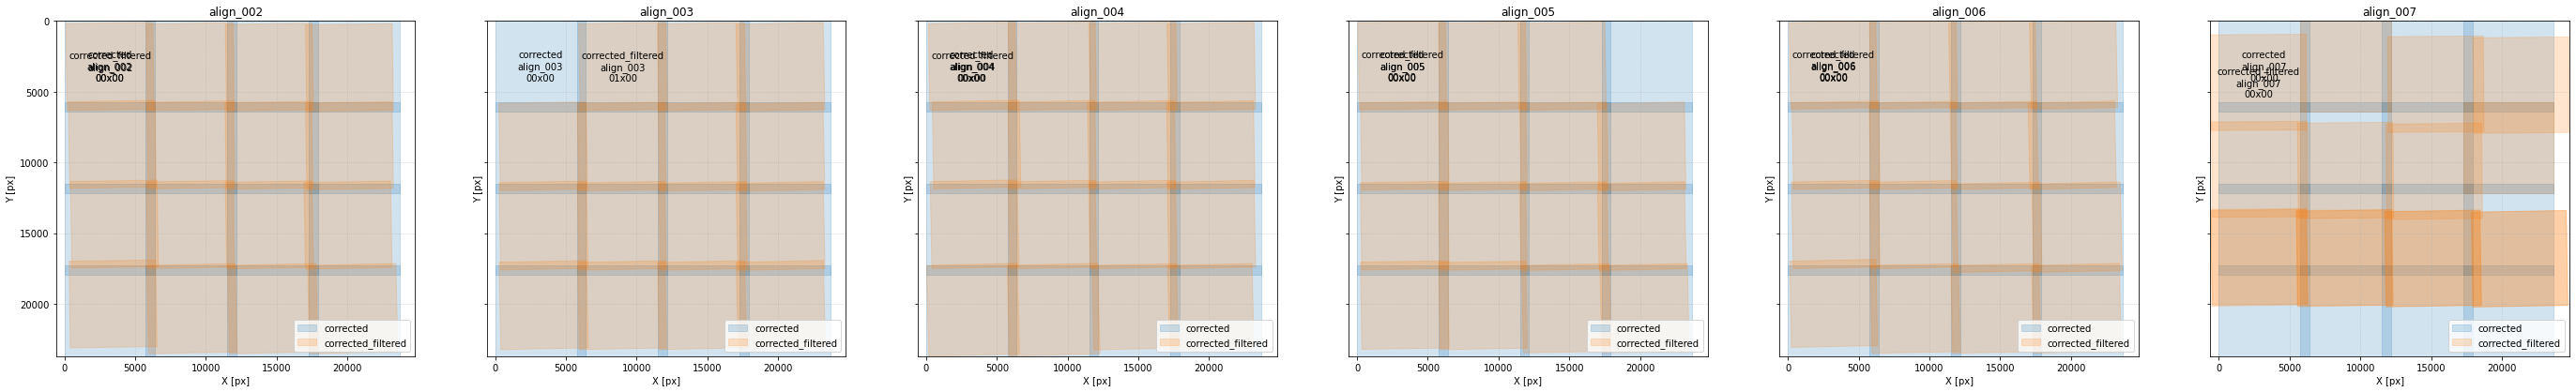

In [113]:
stacks_2_plot = stacks_2_montage + ['corrected_filtered']

icatapi.plotting.plot_tile_map(stacks=stacks_2_plot,
              render=render)